In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import scipy as sp
import json
import torch
torch.set_default_dtype(torch.float64)
device="cpu"
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from rascal.representations import SphericalExpansion
import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm
import chemiscope

In [3]:
from generate_bispectrum_structures import generate_nu3_degen_structs

Generates a bunch of degenerate pairs - closer or farther from being actually symmetric

In [175]:
frames = []
for psi in np.linspace(np.pi/3+np.pi/6, np.pi/3+np.pi*5/6, 3):
    for dphi1 in np.linspace(np.pi*2/3 - 1.2, np.pi*2/3+0.4, 3):
        for dphi2 in np.linspace(np.pi*2/3-0.7, np.pi*2/3+1.3, 3):
            frames += generate_nu3_degen_structs(2, [0, dphi1, dphi1+dphi2], 
                           psi, 1, np.sqrt(5), "Mg", "Mg", "Mg")

In [176]:
cs = chemiscope.show(frames=frames, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)


StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

In [177]:
# frames2 = ase.io.read("mp_equistore/data/hamiltonian/ethanol-hamiltonian/ethanol_4500.xyz",":1")
# frames3= [ase.build.molecule('NH3')]
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

Computes descriptors using librascal and equistore. Retains only the descriptors associated with the central atom

In [178]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 2,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "gaussian_sigma_constant": 0.2,
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
    
}
spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
norm = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm

In [179]:
cg = ClebschGordanReal(5)

In [180]:
gij_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 2,
    "max_angular": 3,
    "gaussian_sigma_type": "Constant",
    "gaussian_sigma_constant": 0.2,
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
}    
pairs = RascalPairExpansion(gij_hypers)
gij = pairs.compute(frames)
gij = operations.slice(gij, samples=Labels(['center'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)

In [181]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

CPU times: user 589 ms, sys: 0 ns, total: 589 ms
Wall time: 588 ms


In [182]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0, filter_sigma=[1])

CPU times: user 494 ms, sys: 0 ns, total: 494 ms
Wall time: 493 ms


In [183]:
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=3)
rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3)
rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0, filter_sigma=[1])

sanity check - this should also be degenerate

In [184]:
rhoi_nu3 = operations.sum_over_samples(rhoii1i2_nu1, sample_names=["structure", "center"]) 

Since we have a LOT of features and few structures, we use PCA to reduce the number of features with no information loss

In [185]:
from sklearn.decomposition import PCA

In [186]:
len(frames)

54

In [187]:
rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0).shape

(184,)

In [188]:
rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0].shape

(120,)

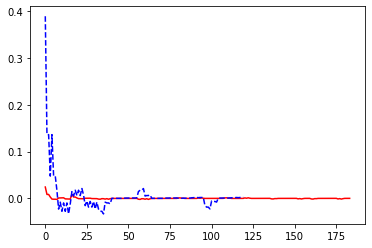

In [189]:
plt.plot(rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0)*2e3,'r-')
plt.plot(rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0], 'b--')

In [190]:
triplet_samples = rhoii1i2_nu1.block(0).samples
raw = rhoii1i2_nu1.block(0).values.squeeze()
feats_n2nu1 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw))
feats_n2nu1 /= np.sqrt((feats_n2nu1**2).sum(axis=1).mean())

In [191]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu123 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [192]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu12345 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [193]:
raw = rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
feats_nu3 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [194]:
raw = rhoi_nu3.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
feats_nu3_alt = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [195]:
feats_nu3.shape

torch.Size([54, 54])

In [196]:
feats_nu3_alt.shape

torch.Size([54, 54])

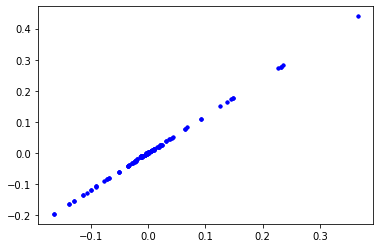

In [197]:
plt.plot(feats_nu3[:,:100].flatten(),feats_nu3_alt[:,:100].flatten(), 'b.')

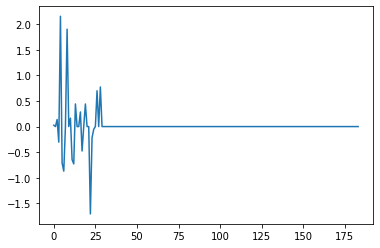

In [198]:
plt.plot(feats_n2nu1[:64].sum(axis=0))

In [199]:
raw = rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()
feats_nu4 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

tensor(8)


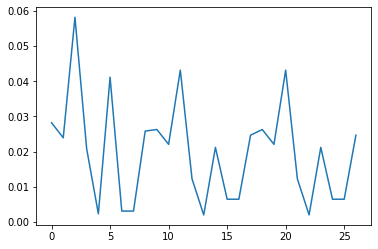

In [200]:
plt.plot(np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1))/np.sqrt(((feats_nu12345[::2]+feats_nu12345[1::2])**2).sum(axis=1)) )
print(np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1)).argmax())

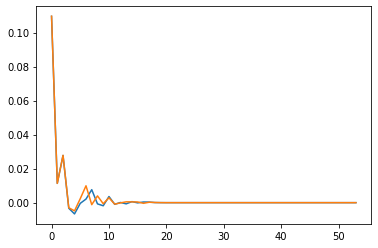

In [201]:
plt.plot(feats_nu12345[4])
plt.plot(feats_nu12345[5])

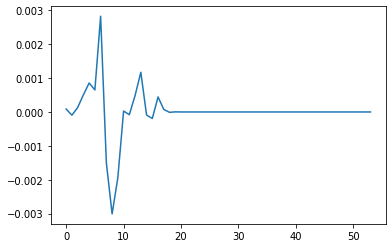

In [202]:
plt.plot(feats_nu12345[20]-feats_nu12345[21])

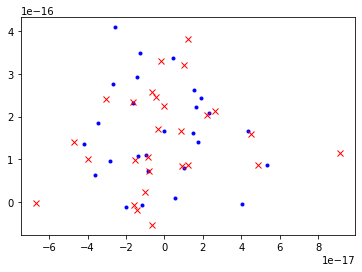

In [203]:
plt.plot(feats_nu123[::2,12], feats_nu123[::2,8], 'b.')
plt.plot(feats_nu123[1::2,12], feats_nu123[1::2,8], 'rx')

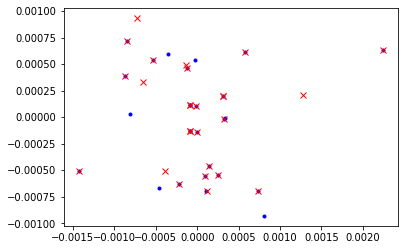

In [204]:
plt.plot(feats_nu12345[::2,12], feats_nu12345[::2,13], 'b.')
plt.plot(feats_nu12345[1::2,12], feats_nu12345[1::2,13], 'rx')

Now we make an autoencoder thingie

In [205]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

def block_compress(block, compress, structure_sel):
    samples = (
        block.samples.view(dtype=np.int32).reshape(-1, len(block.samples.names)).copy()
    )
    if structure_sel is None:
        selected = np.arange(0, len(block.samples))
    else:
        selected = []
        for i in structure_sel:
            selected.append(np.where(block.samples["structure"] == i)[0])
        selected = np.concatenate(selected)
    samples = Labels(block.samples.names, samples[selected])

    new_block = TensorBlock(
        values=torch.tensor(block.values[selected]@compress),
        samples=samples,
        components=block.components,
        properties=Labels(["pca"], np.arange(0, compress.shape[1], dtype=np.int32)[:,np.newaxis]),
    )

    return new_block

def move_and_compress(tensor_map, compress, structure_sel=None):
    blocks = []
    for _, block in tensor_map:
        blocks.append(block_compress(block, compress, structure_sel))

    return TensorMap(tensor_map.keys, blocks)

In [206]:
class EncodeDecodeLinear(torch.nn.Module):
    def __init__(self, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.output_size),            
        )
    
    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [207]:
class EncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.layer_size = layer_size        
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )

    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [942]:
triplet_samples

Labels([(  0, 0, 0, 0), (  0, 0, 0, 1), (  0, 0, 0, 2), ...,
        (319, 0, 7, 5), (319, 0, 7, 6), (319, 0, 7, 7)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor_1', '<i4'), ('neighbor_2', '<i4')])

In [208]:
target = feats_nu12345[:,2:12]

In [209]:
mymodel = EncodeDecodeLinear(24, target.shape[-1])

In [210]:
mymodel = EncodeDecode(48, 24, target.shape[-1])

In [211]:
mymodel.initialize_model_weights(feats_n2nu1, seed=12345)

In [212]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.05,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

In [213]:
len(frames)

54

In [216]:
n_epochs = 100
ntrain = 30
ntriples = 64
for epoch in range(0, n_epochs):
    print("Beginning epoch", epoch)
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(feats_n2nu1[:ntrain*ntriples], triplet_samples["structure"][:ntrain*ntriples])
        loss += loss_mse(predicted, target[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
    predicted = mymodel(feats_n2nu1[ntrain*ntriples:], triplet_samples["structure"][ntrain*ntriples:])
    
    print("Energy RMSE: train ", np.sqrt(loss.detach().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Beginning epoch 0
Energy RMSE: train  0.01104988631279467 test 0.016389278189756756
Beginning epoch 1
Energy RMSE: train  0.010312494054110067 test 0.016060686468204924
Beginning epoch 2
Energy RMSE: train  0.009749631669514803 test 0.016544209242396316
Beginning epoch 3
Energy RMSE: train  0.00910412446044171 test 0.01631133909957941
Beginning epoch 4
Energy RMSE: train  0.00872279832592237 test 0.014952733761256855
Beginning epoch 5
Energy RMSE: train  0.007781426691978518 test 0.014305028012641953
Beginning epoch 6
Energy RMSE: train  0.007653140392227123 test 0.014406141407776532
Beginning epoch 7
Energy RMSE: train  0.00720536298618866 test 0.013598337116000994
Beginning epoch 8
Energy RMSE: train  0.007027470489281074 test 0.013387470185793393
Beginning epoch 9
Energy RMSE: train  0.006844476495201547 test 0.012656003334562006
Beginning epoch 10
Energy RMSE: train  0.006548069657263745 test 0.012348970681283338
Beginning epoch 11
Energy RMSE: train  0.006499219717756597 test 0.01

In [217]:
predicted = mymodel(feats_n2nu1, triplet_samples["structure"])
feats = mymodel.feats(feats_n2nu1, triplet_samples["structure"])

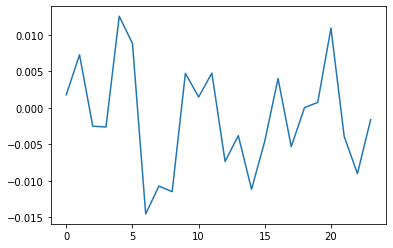

In [218]:
plt.plot(feats[30].detach()-feats[31].detach())

tensor(8)


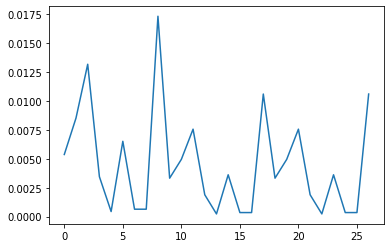

In [219]:
plt.plot(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)))
print(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)).argmax())

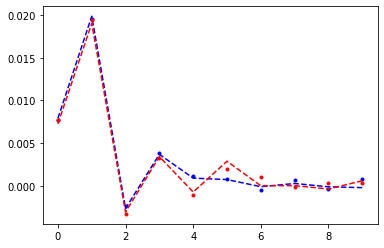

In [221]:
iframe = 18
plt.plot(predicted[iframe].detach(),'b--')
plt.plot(target[iframe].detach(),'b.')
plt.plot(predicted[iframe+1].detach(), 'r--')
plt.plot(target[iframe+1].detach(), 'r.')

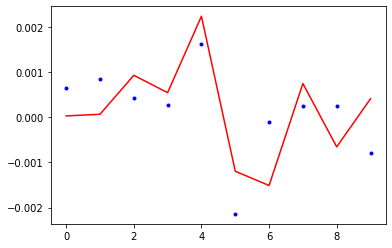

In [222]:
plt.plot((predicted[iframe].detach()-predicted[iframe+1].detach()),'b.')
plt.plot(target[iframe].detach()-target[iframe+1].detach(), 'r-')

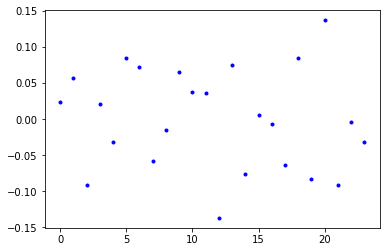

In [223]:
plt.plot((feats[iframe].detach()-feats[iframe+1].detach()),'b.')